In [ ]:
!pip install datasets
!pip install clean-text
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 5.2 MB/s eta 0:

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import re
import nltk
from cleantext import clean
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import torch
from sklearn.metrics import f1_score
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

# Dataset

In this part we read the dataset and we plot the distributions of the labels and the length of all the texts. 
We are dealing with a small dataset containing conspiratorial texts.

In [ ]:
dataset = pd.read_csv("../datasets/subtaskA_train_aug.csv")
dataset = dataset.drop('Id', axis=1)
dataset = dataset.rename(columns={'comment_text': 'text', 'conspiratorial': 'label'})
dataset

,text,label
0,se non ci fossero soldati non ci sarebbero gue...,0
1,shedding of infectious sars-cov-2 despite vac...,1
2,paura e delirio alla cnn: il ministero della v...,1
3,l'aspirina non aumenta la sopravvivenza dei pa...,0
4,l'italia non puo' dare armi lo vieta la costit...,0
...,...,...
3679,Abraccia la terra spesso 2000 km oooh mi ricor...,1
3680,Tuttavia le recensioni erano negative anche pr...,0
3681,"Nel frattempo, in Kazakistan, le persone che h...",1
3682,una profezia ad una conferenza nel 2015: il pr...,1


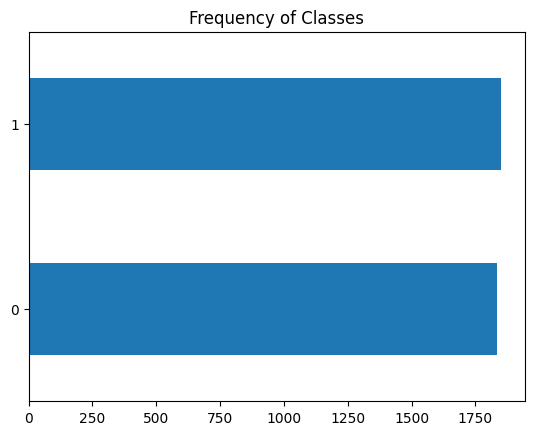

In [ ]:
dataset['label'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

# Text Cleaning

In this section, first of all, we define the function that we will use to clean our text. As we can se above there are some texts between parentesis that are usefull and also unicodes.
We are removing all that stuff creating a text that is similar to the ones used to train the pre-trained model. So, for instance, we won't remove the punctuation and and stopwords.

In [ ]:
# We define the function for the cleaning of the text

def text_cleaning(text):
    # Convert words to lower case
    text = str(text)
    text = text.lower()
    text = clean(text, no_emoji=True)

    text = re.sub(r'(\[.*?\])', '', text)
    text = re.sub(r'[0-9]{2}\/[0-9]{2}\/[0-9]{2,4}', ' ', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'[_"\%()|+&=*%#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\.+','.', text)
    text = re.sub(r'\,+',',', text)
    text = re.sub(r'\!+','!', text)
    text = re.sub(r'\?+','?', text)
    text = re.sub(r'\n+','', text)
    text = re.sub(r' +', ' ', text)
    text = re.sub('[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', text)

    return text

In [ ]:
dataset['text'] = list(map(text_cleaning, dataset.text))
dataset

,text,label
0,se non ci fossero soldati non ci sarebbero gue...,0
1,shedding of infectious sars-cov-2 despite vacc...,1
2,paura e delirio alla cnn: il ministero della v...,1
3,l'aspirina non aumenta la sopravvivenza dei pa...,0
4,l'italia non puo' dare armi lo vieta la costit...,0
...,...,...
3679,abraccia la terra spesso 2000 km oooh mi ricor...,1
3680,tuttavia le recensioni erano negative anche pr...,0
3681,"nel frattempo, in kazakistan, le persone che h...",1
3682,una profezia ad una conferenza nel 2015: il pr...,1


# Model download

In this part we are downloading the bert-model and it's tokenizer from the hugging face hub.
In that specific case we will use the bert multilingual model

In [ ]:
model_name = 'bert-base-multilingual-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [ ]:
# We controll if the device support the computation on the GPU, otherwise we will compute the model on the CPU
device = ('cuda' if torch.cuda.is_available() else 'cpu')

num_labels = 2  # Number of classes
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

## Metrics
We define the metric that we want to calculate during the fine-tuning of the model

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    return {'f1_score': f1}

In [ ]:
def createDataset(train, val):
  tds = Dataset.from_pandas(train)
  vds = Dataset.from_pandas(val)
  dataset_hf = DatasetDict()
  
  dataset_hf['train'] = tds
  dataset_hf['validation'] = vds
  dataset_hf['train']= dataset_hf['train'].remove_columns("__index_level_0__")
  dataset_hf['validation']= dataset_hf['validation'].remove_columns("__index_level_0__")

  return dataset_hf

In [ ]:
# Define a custom collator function with dynamic masking
def collate_fn(batch):
    input_ids = [example['input_ids'] for example in batch]
    labels = [example['label'] for example in batch]

    # Apply dynamic masking
    for i in range(len(input_ids)):
        # Generate a random mask
        mask = [0] * len(input_ids[i])
        for j in range(len(input_ids[i])):
            if random.random() < 0.15:
                mask[j] = 1

        # Apply the mask to the input sequence
        input_ids[i] = [input_ids[i][j] if not mask[j] else tokenizer.mask_token_id for j in range(len(input_ids[i]))]

    # Pad the input sequences
    input_ids = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(input_ids[i]) for i in range(len(input_ids))],
        batch_first=True,
        padding_value=tokenizer.pad_token_id
    )

    # Create the input dictionary
    inputs = {'input_ids': input_ids, 'attention_mask': input_ids != tokenizer.pad_token_id, 'labels': torch.tensor(labels)}

    return inputs

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

## Cross-Validation

Now we will define the cross validation to find the best hyperparameters of the model. This since we have a very small dataset, so we are trying to generalize as much as possible.

In [ ]:
from transformers import DataCollatorWithPadding
import random
import torch


lr_rates = [2e-5, 3e-5]
epochs = [2, 3, 4, 5]
lr_scheduler = ['constant']

log_results_cross = pd.DataFrame({
    'learning_rate': [],
    'epochs': [],
    'f1_score': [],
    'lr_scheduler': []
})


for lr in lr_rates:
  for epoch in epochs:
    for scheduler in lr_scheduler:
      results = []

      for i in range(5):
        # We create the split of the dataset, shuffling before the data
        train, val = train_test_split(dataset, train_size=0.8, shuffle=True)
        df = createDataset(train, val)
        texts_encoded = df.map(tokenize, batched=True, batch_size=None)

        # We define the argument that the model has to use
        batch_size = 8
        logging_steps = len(texts_encoded['train'])
        model_name_hub = f'{model_name}-kcross'
        training_args = TrainingArguments(output_dir=model_name,
                                    num_train_epochs=epoch,
                                    learning_rate=lr,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    weight_decay=0.01,
                                    evaluation_strategy='epoch',
                                    disable_tqdm=False,
                                    logging_steps=logging_steps,
                                    #lr_scheduler_type=scheduler,
                                    fp16=True,
                                    push_to_hub=False,
                                    log_level='error')
        # Train of the model
        trainer = Trainer(model=model,
                    args=training_args,
                    compute_metrics=compute_metrics,
                    train_dataset=texts_encoded['train'],
                    eval_dataset=texts_encoded['validation'],
                    data_collator=collate_fn,
                    tokenizer=tokenizer)
        trainer.train()
        results.append(trainer.predict(texts_encoded['validation']).metrics['test_f1_score'])
    
    # We calculate the mean of the f1_scores and we save the model and the result on a log
    mean_f1_score = sum(results) / len(results)
    print(mean_f1_score)

    # We log the actual parameters and the mean f1_score
    parameters = [lr, epoch, mean_f1_score, scheduler]
    log_results_cross.loc[len(log_results_cross)] = parameters
  
log_results_cross.to_csv('/log_cross_dyn_1.csv')

Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.522779,0.774285
2,No log,0.420883,0.826286


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.676136,0.816790
2,No log,0.546107,0.860193


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.808313,0.843914
2,No log,0.671747,0.879249


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.953059,0.862734
2,No log,0.743806,0.886010


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.008019,0.853369
2,No log,0.717037,0.900955


0.8604570937155376


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.946614,0.875149
2,No log,0.635128,0.898227
3,No log,0.525401,0.907689


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.175788,0.872233
2,No log,0.774017,0.887171
3,No log,0.661274,0.902197


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.893783,0.893820
2,No log,0.650400,0.910443
3,No log,0.767745,0.898193


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.832302,0.804458
2,No log,0.841698,0.899567
3,No log,0.809410,0.900919


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.024095,0.878985
2,No log,0.646119,0.913161
3,No log,0.767387,0.900956


0.8970908524324097


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.866053,0.881904
2,No log,0.844709,0.898223
3,No log,0.727097,0.905026
4,No log,0.600780,0.913157


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.764890,0.877798
2,No log,0.810483,0.892734
3,No log,0.807084,0.903643
4,No log,0.706663,0.911805


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.144651,0.857483
2,No log,0.776062,0.903516
3,No log,0.902679,0.898149
4,No log,0.784490,0.904996


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.981512,0.899580
2,No log,0.892638,0.896858
3,No log,0.890062,0.906372
4,No log,0.793123,0.910450


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.826230,0.899601
2,No log,1.056534,0.883275
3,No log,0.868626,0.913154
4,No log,0.834393,0.914508


0.9101696668835111


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.177874,0.888322
2,No log,1.103931,0.889834
3,No log,0.921417,0.899544
4,No log,0.971641,0.891406
5,No log,0.664428,0.911807


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.112933,0.873705
2,No log,0.971196,0.903669
3,No log,0.779793,0.911743
4,No log,0.788311,0.910433
5,No log,0.700534,0.918594


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.172774,0.899367
2,No log,0.900540,0.881923
3,No log,0.773448,0.907689
4,No log,0.784108,0.909097
5,No log,0.740563,0.907722


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.038754,0.882503
2,No log,0.838324,0.903596
3,No log,0.799418,0.906377
4,No log,0.905464,0.898230
5,No log,0.800813,0.917215


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.977383,0.894152
2,No log,0.935164,0.881656
3,No log,0.713886,0.898233
4,No log,0.825544,0.890010
5,No log,0.732080,0.906384


0.9101679237042959


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.225212,0.896847
2,No log,0.979400,0.915861


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.033356,0.875063
2,No log,0.753356,0.905018


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.721598,0.898131
2,No log,0.735720,0.898210


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.762843,0.891236
2,No log,0.690966,0.905022


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.802059,0.888427
2,No log,0.702159,0.911743


0.8935738477254567


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.026701,0.869185
2,No log,0.582540,0.875332
3,No log,0.704196,0.891459


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.985267,0.872910
2,No log,0.595344,0.882949
3,No log,0.792161,0.879245


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.708313,0.890055
2,No log,0.735629,0.883169
3,No log,0.659750,0.889939


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.788728,0.889939
2,No log,1.122499,0.767538
3,No log,0.795809,0.877426


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.721533,0.890102
2,No log,0.724952,0.887143
3,No log,0.767167,0.880440


0.8923134092536478


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.726668,0.887266
2,No log,0.887485,0.851570
3,No log,0.667602,0.881640
4,No log,0.692104,0.890027


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.610975,0.876233
2,No log,0.725275,0.879147
3,No log,0.593630,0.880514
4,No log,0.649484,0.880577


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.724826,0.880604
2,No log,0.541691,0.894114
3,No log,0.963307,0.800289
4,No log,0.669163,0.468527


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.675104,0.839647
2,No log,0.856180,0.830342
3,No log,0.691946,0.864077
4,No log,0.732312,0.869749


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.535691,0.877868
2,No log,0.588181,0.879116
3,No log,0.690712,0.879215
4,No log,0.696927,0.888732


0.7979770256123898


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.738743,0.873620
2,No log,0.616583,0.885783
3,No log,0.762612,0.879116
4,No log,0.710078,0.889862
5,No log,0.656362,0.894114


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.693134,0.881954
2,No log,0.594039,0.894148
3,No log,0.735741,0.876198
4,No log,0.638770,0.892817
5,No log,0.614023,0.895527


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.960519,0.871841
2,No log,0.720437,0.884175
3,No log,0.661105,0.898180
4,No log,0.763518,0.890061
5,No log,0.724949,0.891368


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.148421,0.815565
2,No log,0.719522,0.890001
3,No log,0.782281,0.814547
4,No log,0.695343,0.865191
5,No log,0.686732,0.864010


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.710543,0.877640
2,No log,0.635092,0.887387
3,No log,0.628098,0.895505
4,No log,0.680662,0.892803
5,No log,0.669910,0.892749


0.8891587884050616


# Train final Model

Now that we finished the cross-validation, we take the best model found and we buil the final model.
Then, we push the model into the hugging face hub

In [ ]:
train, val = train_test_split(dataset, train_size=0.8, shuffle=True)
dataset_final_train = createDataset(train, val)
dataset_final_encoded = dataset_final_train.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

In [ ]:
import random

# We take the best parameter from the log
idx_best_model = log_results_cross['f1_score'].idxmax()
learning_rate_best = log_results_cross['learning_rate'][idx_best_model]
epoch_best = float(log_results_cross['epochs'][idx_best_model])
#lr_scheduler_best = log_results_cross['lr_scheduler'][idx_best_model]

# Define a custom collator function with dynamic masking
def collate_fn(batch):
    input_ids = [example['input_ids'] for example in batch]
    labels = [example['label'] for example in batch]

    # Apply dynamic masking
    for i in range(len(input_ids)):
        # Generate a random mask
        mask = [0] * len(input_ids[i])
        for j in range(len(input_ids[i])):
            if random.random() < 0.15:
                mask[j] = 1

        # Apply the mask to the input sequence
        input_ids[i] = [input_ids[i][j] if not mask[j] else tokenizer.mask_token_id for j in range(len(input_ids[i]))]

    # Pad the input sequences
    input_ids = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(input_ids[i]) for i in range(len(input_ids))],
        batch_first=True,
        padding_value=tokenizer.pad_token_id
    )

    # Create the input dictionary
    inputs = {'input_ids': input_ids, 'attention_mask': input_ids != tokenizer.pad_token_id, 'labels': torch.tensor(labels)}

    return inputs

# We define the arguments for the training 
batch_size = 8
logging_steps = len(dataset_final_encoded['train'])
model_name_hub = 'prova'

# We train the final model
training_args = TrainingArguments(output_dir=model_name_hub,
                                  num_train_epochs=epoch_best,
                                  learning_rate=learning_rate_best,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  #lr_scheduler_type=lr_scheduler_best,
                                  fp16=True,
                                  push_to_hub=True,
                                  log_level='error')

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_final_encoded['train'],
                  eval_dataset=dataset_final_encoded['validation'],
                  data_collator=collate_fn,
                  tokenizer=tokenizer)
trainer.train()
trainer.push_to_hub()

/content/prova is already a clone of https://huggingface.co/Mike00vito/prova. Make sure you pull the latest changes with `repo.git_pull()`.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.442381,0.774193
2,No log,0.532595,0.799353
3,No log,0.496880,0.868120
4,No log,0.544405,0.876239


Upload file pytorch_model.bin:   0%|          | 1.00/638M [00:00<?, ?B/s]

Upload file runs/May05_22-43-34_3c244ea3da08/events.out.tfevents.1683326617.3c244ea3da08.3116.2:   0%|        …

To https://huggingface.co/Mike00vito/prova
   508b5d6..28af4a7  main -> main

   508b5d6..28af4a7  main -> main

To https://huggingface.co/Mike00vito/prova
   28af4a7..4f1be07  main -> main

   28af4a7..4f1be07  main -> main



'https://huggingface.co/Mike00vito/prova/commit/28af4a72c3f07b116e27ec6942b76cbe6ca63fd3'